In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-43z4y4_1
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-43z4y4_1
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import e,sqrt
from pyFTS.fcm import Activations
from pyFTS.models import hofts
from numpy.linalg import svd
from pyFTS.fcm import fts as fcm_fts
from pyFTS.partitioners import Grid
from pyFTS.common import Util
from pyFTS.common import Membership as mf
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from pyFTS.benchmarks import Measures
import math
import pdb
import math
from pyFTS.benchmarks import Measures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [ ]:
#defining FCM
class FuzzyCognitiveMap(object):
    def __init__(self, **kwargs):
        super(FuzzyCognitiveMap, self).__init__()
        self.order = kwargs.get('order',1)
        self.concepts = kwargs.get('partitioner',None)
        self.weights = []
        self.bias=[]
        self.activation_function = kwargs.get('activation_function', Activations.sigmoid)
        #self.activation_function=softplus

        #self.concepts = self.partitioner


    def activate(self, memberships):
        dot_products = np.zeros(len(self.concepts))
        for k in np.arange(0, self.order):
            dot_products += np.dot(np.array(memberships[k]).T, self.weights[k])+(self.bias[k])
        return self.activation_function( dot_products )


In [ ]:
# Function for the last layer for least squares
def func(values, *arg):

    # values -> predicted values

    #print(values.shape)
    if len(values.shape) == 1:
      n_coefs = values.shape[0] + 1
      #return arg[0] + np.sum([values[i-1] * arg[i] for i in np.arange(1,n_coefs)])
      ret = 0
    else:
      n_coefs = values.shape[0] + 1
      n_inst = values.shape[1]
      ret = np.zeros(n_inst)
    for k in range(1, n_coefs):
      ret = ret + arg[k] * values[k-1]

    ret = ret + arg[0]

    return ret

In [ ]:
#%%debug
# RHFCM Model
class FCM_FTS(hofts.HighOrderFTS):

    def __init__(self, **kwargs):
        super(FCM_FTS, self).__init__(**kwargs)


        num_concepts = self.partitioner.partitions # Number of concepts

        self.num_concepts = kwargs.get('num_concepts', 4)

        self.num_fcms = kwargs.get('num_fcms', 2)   # The number of sub-reservoir (layers)

        self.loss_function = kwargs.get('loss', func) # Loss function for OLS method

        self.orderMax = kwargs.get('orderMax', 4)

        #print(self.orderMax)

        #self.partitioner = kwargs.get('partitioner',Grid.GridPartitioner(data=data, npart=self.num_concepts, mf=mf.trimf))

        #self.partitioner = Grid.GridPartitioner(data=data, npart=self.num_concepts, mf=mf.trimf)

        #print(self.partitioner)

        #print(self.orderMax)


        self.fcm = [] # Initialization of fcm (empty)

        # Weight initialization
        for k in range(self.num_fcms):
          # np.random.seed(42+10*k+200)     # HERE
          fcm_tmp = FuzzyCognitiveMap(**kwargs)
          weights = np.random.uniform(-1, 1, size=(self.order,num_concepts, num_concepts))
          specturalradius1=np.max(np.abs(np.linalg.eigvals(weights)))
          fcm_tmp.weights = weights*0.5/specturalradius1
          # np.random.seed(35+10*k+200)     # HERE
          bias = np.random.uniform(-1, 1, size=(self.order,num_concepts))
          U,S,VT=svd(bias) # Not square
          specturalradius2=np.max(S)
          fcm_tmp.bias=bias*0.5/specturalradius2    # epsilon = 0.5
          self.fcm.append(fcm_tmp)


        # Coefficients
        self.theta = np.random.rand(self.num_fcms + 1) # Initialization for least squares


    def forecast(self, data, **kwargs):
        y1 = []

        midpoints = np.array([fset.centroid for fset in self.partitioner])


        #if self.order == 3:
        #  pdb.set_trace()
        #print('Number of layers: ')
        #print(type(self.fcm))
        #print(np.shape(self.fcm))
        #print(self.fcm[0].weights)
        #print(self.fcm[0].concepts)


        #for t in np.arange(self.order, len(data)+1):   # Sweeping all data points depending of the order ------ CHANGE VARIABLE HERE!!!!!!
        for t in np.arange(self.orderMax, len(data)+1):   # Sweeping all data points depending of the order ------ CHANGE VARIABLE HERE!!!!!!

            sample = data[t - self.order : t]

            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')

            # Evaluate FCMs

            forecasts = []

            for fcm in self.fcm:
              activation=fcm.activate(fuzzyfied)
              forecasts.append(np.dot(midpoints, activation)/np.nanmax([1, np.sum(activation)]))    # Forecasting

            # Combine the results

            #print(forecasts)

            result = self.loss_function(np.array(forecasts), *self.theta)

            if str(result) == 'nan' or result == np.nan or result == np.Inf:
               print('error')

            y1.append(result)

        return y1

    def run_fcm(self, fcm, data):
        ret = []

        midpoints = np.array([fset.centroid for fset in self.partitioner])
        #for t in np.arange(self.order, len(data)+1):   # Sweeping all data points. ------ CHANGE VARIABLE HERE!!!!!!
        for t in np.arange(self.orderMax, len(data)+1):   # Sweeping all data points. ------ CHANGE VARIABLE HERE!!!!!!
            sample = data[t - self.order : t]
            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')
            activation = fcm.activate(fuzzyfied)
            final = np.dot(midpoints, activation)/np.nanmax([1, np.sum(activation)])
            ret.append(final)
        return ret

    def outputEstimation(self, data, **kwargs):
        #from scipy.optimize import curve_fit, least_squares, minimize, leastsq
        from scipy.optimize import leastsq
        from sklearn.linear_model import Ridge
        from sklearn import linear_model

        outputs = []

        for model in self.fcm:
          outputs.append(self.run_fcm(model, data)[:-1])
          #print(outputs)
        #OLS

        #f = lambda coef, y, x: self.loss_function(x, *coef) - y    # x -> output of the subreservoir

        # y -> real data
        # x -> predicted values

        #self.theta, flag = leastsq(f, x0 = self.theta, args=(data[self.order:], np.array(outputs)))
        #print('Coefs OLS')
        #print(self.theta)
        return outputs


In [ ]:
def trainRegression(data,outputs,orderMax, typeRegression):

  from scipy.optimize import leastsq
  from sklearn.linear_model import Ridge
  from sklearn import linear_model

  if typeRegression == 'Lasso':
    ##### Lasso
    from sklearn.linear_model import LassoCV

    ##### Lasso
    # Crossvalidation (Finding the best alpha)
    resultsCV = LassoCV(cv=5, random_state=0).fit(np.array(outputs).T, data[orderMax:])
    print(f'resultsCV.alpha_: {(resultsCV.alpha_)}')

    lassoModel = linear_model.Lasso(alpha=resultsCV.alpha_)

    lassoModel.fit(np.array(outputs).T, data[orderMax:])
    tetha = np.concatenate((np.array([lassoModel.intercept_]),lassoModel.coef_))


    # lassoModel = linear_model.Lasso(alpha=100000)
    # lassoModel.fit(np.array(outputs).T, data[orderMax:])
    # tetha = np.concatenate((np.array([lassoModel.intercept_]),lassoModel.coef_))

  if typeRegression == 'Ridge':
    ##### Ridge of regression
    clf = Ridge(alpha=.1)
    clf.fit(np.array(outputs).T, data[orderMax:])
    tetha = np.concatenate((np.array([clf.intercept_]),clf.coef_))

  return tetha

In [ ]:
def CalculateCoef(data, set_parts, set_orders, set_layers, orderMax):
  train = data.values[:1500]

  # train = df['load'].values[:6500]
  #test = df['load'].values[:6500]
  test = data.values[:500]
  estimated_outputs_train = []
  estimated_outputs_test=[]
  for ii in set_parts:
    for jj in set_orders:

      for kk in set_layers:

        partitioner = Grid.GridPartitioner(data=data, npart=ii, mf=mf.trimf)
        model = FCM_FTS(partitioner=partitioner, order=jj, num_fcms= kk,
                    activation_function=Activations.sigmoid,
                    loss=func, orderMax=orderMax)

        aux_train=model.outputEstimation(train)
        aux_test=model.outputEstimation(test)
        estimated_outputs_train = estimated_outputs_train + aux_train

        estimated_outputs_test = estimated_outputs_test + aux_test

  return estimated_outputs_train, model,estimated_outputs_test

In [ ]:
# Malaysia load dataset
df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')
# data = df['load'].values[:8760]
data=df['load']


train = df['load'].values[:1500]

# # train = df['load'].values[:6500]
# #test = df['load'].values[:6500]
test = df['load'].values[:500]


# Hyperparameters
#set_parts = [3,4,5,6]
#set_orders = [2,3,4,5]

set_parts = [3,4]
set_orders = [2,3]

#numLayers =40
set_layers = [5,10]
orderMax = np.max(set_orders)

# model = []
#
#estimated_outputs_train, model,estimated_outputs_test = CalculateCoef(data, set_parts, set_orders, numLayers, orderMax)
estimated_outputs_train, model,estimated_outputs_test = CalculateCoef(data, set_parts, set_orders, set_layers, orderMax)


lambdas = trainRegression(train,estimated_outputs_train,orderMax=orderMax, typeRegression='Lasso')

print(lambdas)




resultsCV.alpha_: 52244.19650564911
[-6.68758313e+04 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.83656394e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -7.30885240e+00
 -0.00000000e+00  0.00000000e+00 -1.46971822e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  9.26693105e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.86063401e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  2.61220001e+00  0.00000000e+00  2.66109914e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -9.72927923e-01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.66603673e-01  0.00

In [ ]:
np.shape(estimated_outputs_test)

(60, 497)

In [ ]:
# theta[0] + theta[1]*x[0] + theta[2]*x[1]

y_pred=lambdas[0]
for i in range(len(estimated_outputs_test)):
  y_pred=y_pred+lambdas[i+1]*np.array(estimated_outputs_test[i])




In [ ]:

test = df['load'].values[orderMax:500]
rmse = round(Measures.rmse(test,y_pred),3)

In [ ]:
rmse

2447.481

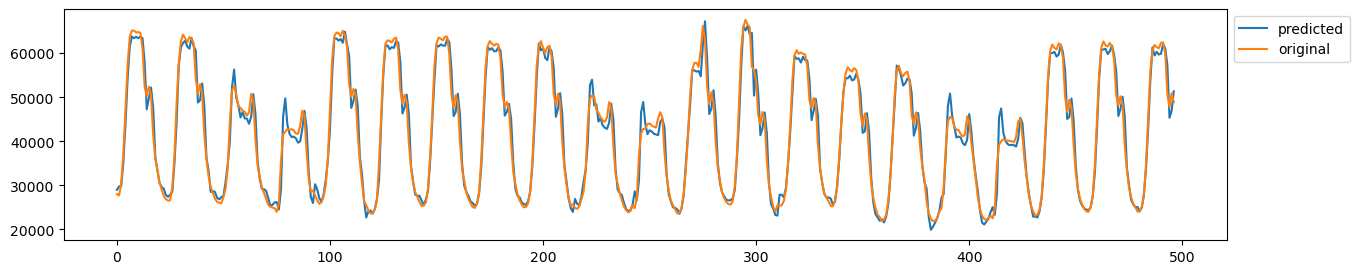

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(y_pred,label='predicted')
ax.plot(test,label='original')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

# Sliding window cross validation

In [ ]:
import math
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)
def sliding_window(data):
  result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "nrmse": []

    }
  #set_parts = [3,4,5,6,7,8,9,10,20]
  #set_orders = [2,3,4,5,6]

  set_parts = [3,4,5,7,10]
  set_orders = [2,3,4,5]

  set_layers = [5,10,20,40,60]
  #numLayers =5
  orderMax = np.max(set_orders)
  for  count,train, test in Util.sliding_window(data, windowsize=2000, train=0.8, increment_rate=0.2):
    print(f'training window {(count)}')

    estimated_outputs_train = []
    estimated_outputs_test=[]
    for ii in set_parts:
      for jj in set_orders:

        for kk in set_layers:

          partitioner = Grid.GridPartitioner(data=train, npart=ii, mf=mf.trimf)
          model = FCM_FTS(partitioner=partitioner, order=jj, num_fcms=kk,
                        activation_function=Activations.relu,
                        loss=func, orderMax=orderMax)

          aux_train=model.outputEstimation(train)
          aux_test=model.outputEstimation(test)
          estimated_outputs_train = estimated_outputs_train + aux_train

          estimated_outputs_test = estimated_outputs_test + aux_test

    lambdas = trainRegression(train,estimated_outputs_train,orderMax=orderMax, typeRegression='Lasso')
    print(f'lambdas:{(lambdas)}')

    y_pred=lambdas[0]
    for i in range(len(estimated_outputs_test)):
      y_pred=y_pred+lambdas[i+1]*np.array(estimated_outputs_test[i])


    original=test[orderMax:]
    forecast=y_pred
    mae = round(mean_absolute_error(original,forecast),3)
    rmse = round(Measures.rmse(original,forecast),3)
    mape = round(Measures.mape(original,forecast),3)
    nrmse = round(cal_nrmse(rmse, original),3)

    result["rmse"].append(rmse)
    result["nrmse"].append(nrmse)
    result["mape"].append(mape)
    result["mae"].append(mae)
    result["window"].append(count)
  measures = pd.DataFrame(result)
  return measures

In [ ]:
df=pd.read_csv('/home/omid-orang/omid/AL-RHFCM/Datasets//DEOK_hourly.csv')
data = df['DEOK_MW'].values[:8000]
for experiment in range(0,1):
    print('n_experiment is:', experiment)
    result_large_resrevoir =  sliding_window(data=data)

In [ ]:
print(result_large_resrevoir)

    window     rmse    mape      mae  nrmse
0        0   78.974   2.332   61.033  0.061
1      200   77.210   2.242   57.437  0.062
2      400   71.008   2.049   52.509  0.056
3      600   75.712   2.084   52.912  0.056
4      800  283.147   3.929  130.931  0.103
5     1000  615.018  10.219  395.315  0.230
6     1200  150.184   3.370  111.559  0.061
7     1400  101.136   2.423   76.482  0.040
8     1600  197.715   2.975  104.966  0.063
9     1800  218.015   3.454  132.097  0.071
10    2000  156.562   2.783  102.802  0.051
11    2200  144.479   2.541   94.422  0.048
12    2400  130.617   2.249   84.218  0.046
13    2600  151.960   2.389   86.103  0.049
14    2800  136.077   2.186   73.827  0.044
15    3000   94.525   1.916   60.686  0.034
16    3200  113.341   2.832   79.807  0.046
17    3400  116.347   2.948   84.460  0.046
18    3600   96.240   2.316   66.060  0.039
19    3800   93.739   2.566   69.926  0.045
20    4000   93.629   2.517   68.297  0.045
21    4200   88.193   2.440   64

In [ ]:
result_large_resrevoir.to_csv('/home/omid-orang/AL-RHFCM/DEOK/result_LR-HFCM.csv')

In [ ]:
import statistics
final_result = {
     "rmse": [],
     "mae": [],
     "nrmse": [],
    "mape": []
}

measures = result_large_resrevoir

rmse = round(statistics.mean(measures.loc[:,'rmse']),3)
nrmse = round(statistics.mean(measures.loc[:,'nrmse']),3)
mae = round(statistics.mean(measures.loc[:,'mae']),3)
mape = round(statistics.mean(measures.loc[:,'mape']),3)


final_result["rmse"].append(rmse)
final_result["nrmse"].append(nrmse)
final_result["mae"].append(mae)
final_result["mape"].append(mape)



In [ ]:
final=pd.DataFrame(final_result)
print(final)

      rmse     mae  nrmse   mape
0  131.913  86.427  0.062  2.747
